A notebook to calculate data for the Bayesian bot (analogous to training for ML bots)

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
from copy import deepcopy
import json

import draftsimtools as ds

In [2]:
# Load M19 drafts
raw_drafts = ds.load_drafts("../../data/m19_2.csv")

In [3]:
# Here other folks load card lists, but I grab them from json instead
# m19_set = ds.create_set("data/m19_rating.tsv", "data/m19_land_rating.tsv")
with open('../../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON['M19']['cards']
thisSet = {card['name'] : card for card in jsonSubset}

In [5]:
# Create a list of names + lots of other useful stuff
nameList = pd.DataFrame.from_dict(thisSet, orient='index', columns=['colors','rarity','type','convertedManaCost'])
nameList['Name'] = nameList.index                 # We need names as a column, not an index
nameList['index'] = range(len(nameList))
nameList = nameList.set_index('index')     # And we need a normal numerical index
nameList[1:5]

,colors,rarity,type,convertedManaCost,Name
index,,,,,
1,[R],common,Sorcery,3.0,Act of Treason
2,[W],uncommon,Instant,2.0,Aegis of the Heavens
3,"[U, W]",uncommon,Creature — Human Artificer,4.0,Aerial Engineer
4,[U],uncommon,Enchantment — Aura,2.0,Aether Tunnel


In [6]:
# Process names, then handle weird card names (those with commas)
nameList['Name'] = nameList.Name.str.replace(' ','_')

# This utility method searches for "Name" column in nameList that have commas
nameList, raw_drafts = ds.fix_commas(nameList, raw_drafts) # Returns a tuple, as it updates both
# nameList.Name[nameList.Name.str.find(',')!=-1] # There should be no longer any cards with commas

In [7]:
# Process the drafts, deconstructing packs (hands) at every turn of every draft
drafts = ds.process_drafts(raw_drafts)

Processing draft: 0.
Processing draft: 10000.
Processing draft: 20000.
Processing draft: 30000.
Processing draft: 40000.
Processing draft: 50000.
Processing draft: 60000.
Processing draft: 70000.
Processing draft: 80000.
Processing draft: 90000.
Processing draft: 100000.


### Make sure all cards are listed, even weird foils

In [9]:
# Make sure all cards are listed in the nameList; update if necessary
for iDraft in range(200): #range(len(subset_drafts)):
    if iDraft>0 and iDraft % 100 == 0:
        print("Draft #%d" % iDraft)
    draft = drafts[iDraft]
    for pack in draft[1:100]: # Let's assume that first 100 drafts cover all the bases     
        for cardName in pack:
            try:
                pos = nameList[nameList.Name==cardName].index[0]
            except:
                print("---Unrecognized card: ",cardName) # All unrecognized cards here seem to be foil lands
                #  	colors 	rarity 	type 	convertedManaCost 	Name
                nameList = nameList.append({'colors':[],'rarity':'weird','type':'weird',
                                            'convertedManaCost':0,'Name':cardName},ignore_index=True)

---Unrecognized card:  Mountain_4
---Unrecognized card:  Forest_4
---Unrecognized card:  Plains_2
---Unrecognized card:  Mountain_2
---Unrecognized card:  Island_1
---Unrecognized card:  Forest_2
---Unrecognized card:  Swamp_1
---Unrecognized card:  Mountain_3
---Unrecognized card:  Forest_1
---Unrecognized card:  Island_4
---Unrecognized card:  Swamp_3
---Unrecognized card:  Plains_1
---Unrecognized card:  Swamp_4
---Unrecognized card:  Plains_4
---Unrecognized card:  Forest_3
---Unrecognized card:  Island_3
---Unrecognized card:  Swamp_2
---Unrecognized card:  Plains_3
---Unrecognized card:  Mountain_1
---Unrecognized card:  Island_2
Draft #100


### Calculate all the stats

In [74]:
nCardsInSet = len(nameList)
pCoDraft = np.zeros([nCardsInSet,nCardsInSet])
pChoice = np.zeros([nCardsInSet,nCardsInSet])

In [75]:
# Main loop:

for iDraft in range(50): #range(len(subset_drafts)): # <----- Uncomment this to ran it on a full dataset
    if iDraft>0 and iDraft % 100 == 0:
        print("Draft #%d" % iDraft)
    draft = drafts[iDraft]
    collection = np.zeros(nCardsInSet)
    for pack in draft:     
        packVector = np.zeros(nCardsInSet)
        for cardName in pack:            
            pos = nameList[nameList.Name==cardName].index[0]            
            packVector[pos] += 1  # Mark the card
            if cardName==pack[0]: # If the first card in the pack, note it, as the Human picked it
                humanCard = pos

        humanPick = np.zeros(nCardsInSet)
        humanPick[humanCard] = 1
        pChoice += np.outer(humanPick,packVector)
        collection[humanCard] += 1 # Update collection
                
        #print(iDraft,iCard,nameList.iloc[humanCard]['Name'],nameList.iloc[humanCard]['colors'],
        #                   nameList.iloc[botCard]['Name'],  nameList.iloc[botCard]['colors'])
        
    # -- Out of drafting: Final collection
    pCoDraft += np.outer(collection,collection)-np.diag(collection) # Diagonal: n^2-n = n(n-1)
    
# -- Out of loop: Final adjustments to everything
pCoDraft[range(nCardsInSet),range(nCardsInSet)] = pCoDraft[range(nCardsInSet),range(nCardsInSet)]/2 
# Scale diagonal by 0.5, to get n(n-1)/2
np.fill_diagonal(pChoice,0) # Weird method that modifies its argument instead of returning something
print('Done')

Done


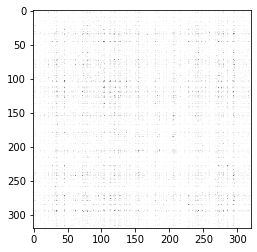

In [76]:
plt.imshow(pCoDraft, cmap="Greys");

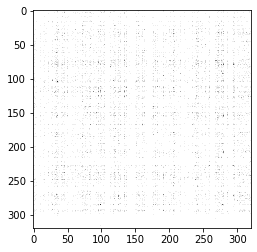

In [81]:
plt.imshow(pChoice, cmap="Greys");

In [ ]:
np.savetxt('bots_data/pCoDraft.csv', pCoDraft, delimiter=",")
np.savetxt('bots_data/pChoice.csv', pChoice, delimiter=",")

In [94]:
# Let's make sure that the preference matrix (pChoice) makes sense
rating = sum(pChoice)
rating = np.argsort(rating)
nameList.iloc[rating[:10]] # 10 most preferred cards
#nameList.iloc[rating[-10:]] # 10 least preferred cards

,colors,rarity,type,convertedManaCost,Name
263,[],uncommon,Artifact Creature — Golem,3.0,Tezzeret's_Strider
289,[G],mythic,Legendary Planeswalker — Vivien,6.0,Vivien_of_the_Arkbow
171,[U],mythic,Instant,7.0,Nexus_of_Fate
288,[G],mythic,Legendary Planeswalker — Vivien,5.0,Vivien_Reid
147,[B],mythic,Legendary Planeswalker — Liliana,5.0,Liliana_the_Necromancer
187,[],common,Artifact,2.0,Pendulum_of_Patterns
233,[G],rare,Creature — Wolf Spirit,5.0,Skalla_Wolf
132,[R],common,Creature — Human Warrior,2.0,Kargan_Dragonrider
136,[R],rare,Legendary Creature — Dragon,6.0,Lathliss_Dragon_Queen
280,[G],common,Creature — Human Berserker,2.0,Ursine_Champion


In [39]:
# Playground for co-occurrence matrix
a = np.array([0,1,0,0,2,1,3])
b = np.outer(a,a)-np.diag(a)
# b = b*(np.ones(7)-np.eye(7)) + np.diag(np.diag(b)/2) # Horrible way
b[range(7),range(7)] = b[range(7),range(7)]/2 # Scale diagonal by 0.5
b

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 1, 3],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 1, 2, 6],
       [0, 1, 0, 0, 2, 0, 3],
       [0, 3, 0, 0, 6, 3, 3]])

In [56]:
# Playground for preference matrix
a = np.array([0,1,0,1,2]) # pack
b = 1 # Card that was taken (with zero indexing)
c = np.zeros(5)
c[b] = 1
np.outer(c,a)-np.diag(c)
# A_ij counts how many time card i won over card j

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 2.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])